In [1]:
import pandas as pd
import numpy as np

from google.colab import files
uploaded = files.upload()

Saving DABUR.NS.csv to DABUR.NS.csv


In [2]:
import io
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv(io.BytesIO(uploaded['DABUR.NS.csv']),index_col='Date',parse_dates=['Date'], date_parser=dateparse)
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-08-07,307.799988,312.799988,302.799988,309.100006,291.463745,836126.0
2015-08-10,310.799988,313.899994,304.500000,305.350006,287.927734,446877.0
2015-08-11,307.750000,307.750000,299.500000,299.899994,282.788666,813838.0
2015-08-12,300.000000,302.700012,295.500000,298.399994,281.374237,924412.0
2015-08-13,299.000000,301.250000,290.500000,292.000000,275.339386,1239094.0


In [3]:
df = df.ffill()
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
pip install pmdarima

In [5]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

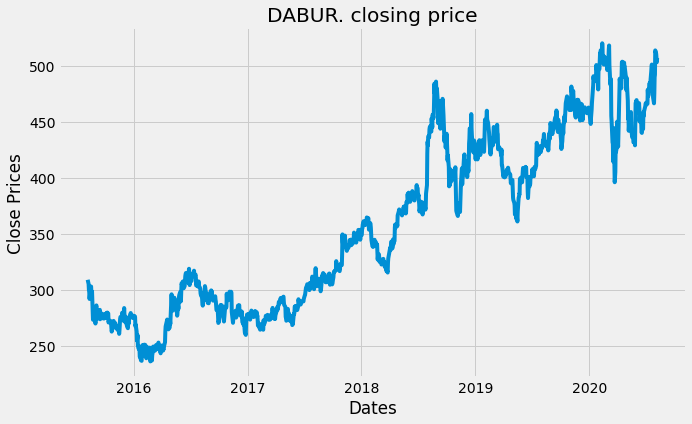

In [6]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('DABUR. closing price')
plt.show()

### Here we can observe there is an obvious trend but seasonality is not seen here.

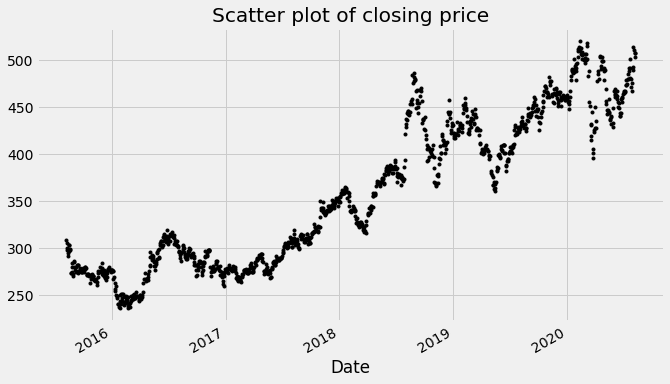

In [7]:
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

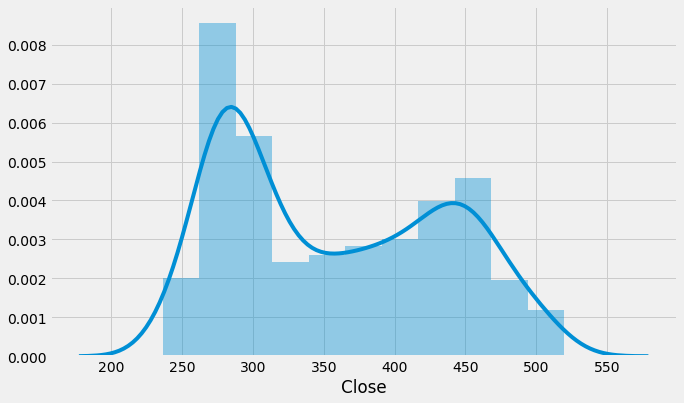

In [8]:
import seaborn as sns
sns.distplot(df['Close'])
plt.show()

### From the graph we can interpret the data is not normally distributed

## Dickey fuller test
H0: Time series is not stationary                                        
H1: Time series is stationary

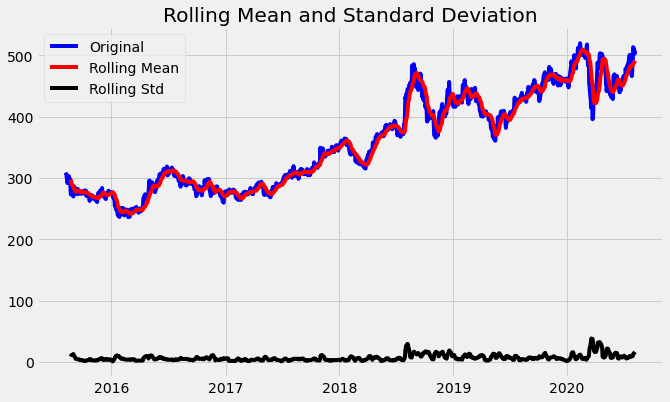

Results of dickey fuller test
Test Statistics                  -0.661573
p-value                           0.856453
No. of lags used                 13.000000
Number of observations used    1215.000000
critical value (1%)              -3.435744
critical value (5%)              -2.863922
critical value (10%)             -2.568038
dtype: float64


In [9]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

df_close = df['Close']
test_stationarity(df_close)

## As p-value for dickey fuller test is greater than 0.05 null hypothesis is excepted that is the Time series is non- stationary

<Figure size 720x432 with 0 Axes>

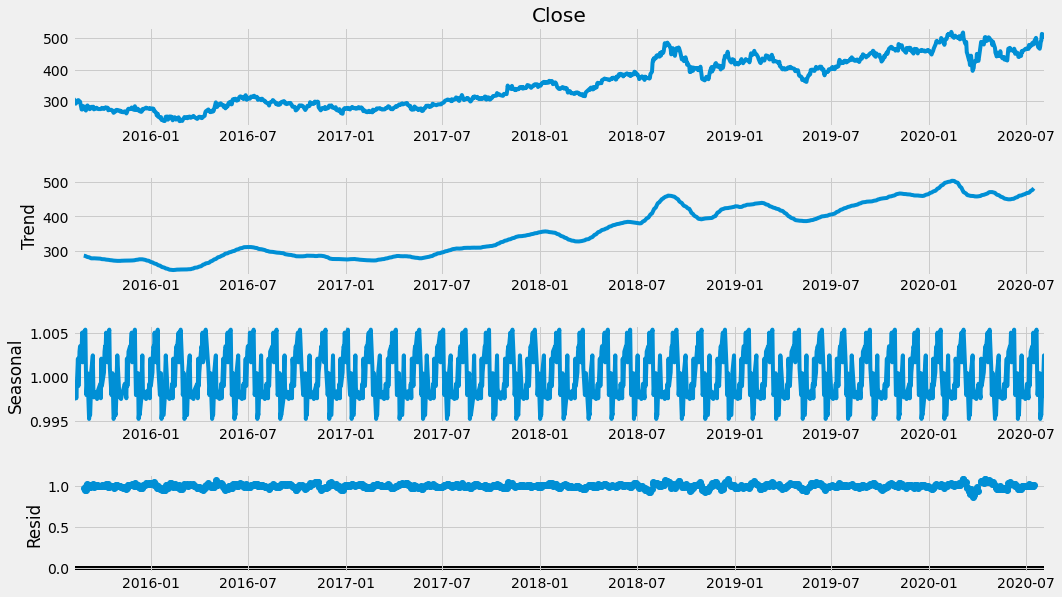

In [10]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

## As the Time series is not stationary ie. there is trend, we will stationaries the series using Log function

No handles with labels found to put in legend.


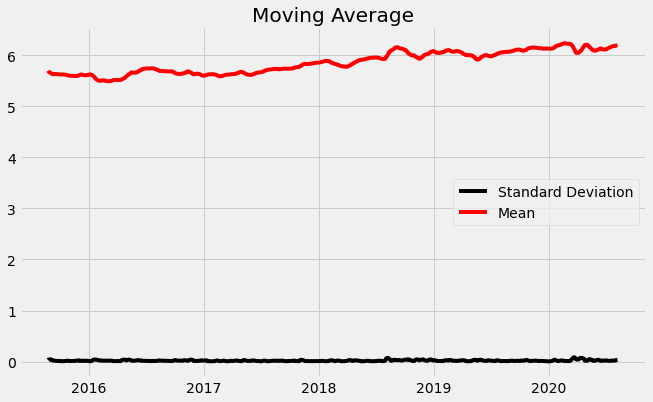

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

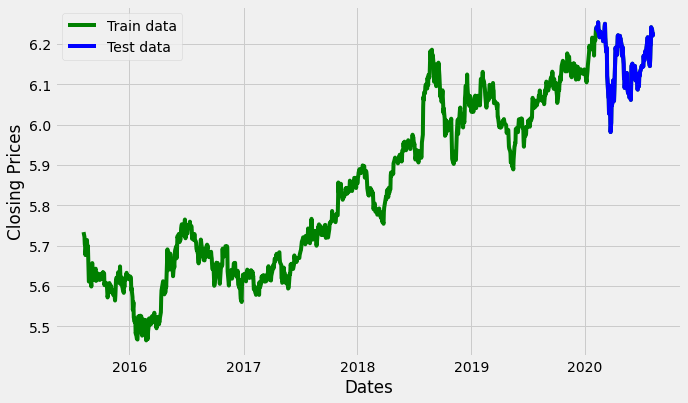

In [12]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

# Modelling

In [13]:
# Build Model
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1102
Model:                 ARIMA(3, 1, 2)   Log Likelihood                3084.865
Method:                       css-mle   S.D. of innovations              0.015
Date:                Sun, 13 Sep 2020   AIC                          -6155.730
Time:                        08:48:05   BIC                          -6120.695
Sample:                             1   HQIC                         -6142.477
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.140      0.254      -0.000       0.001
ar.L1.D.Close     0.1752      0.064      2.733      0.006       0.050       0.301
ar.L2.D.Close    -0.9469      0.039    -

In [14]:
# Forecast
fc, se, conf = fitted.forecast(123, alpha=0.05)  # 95% conf

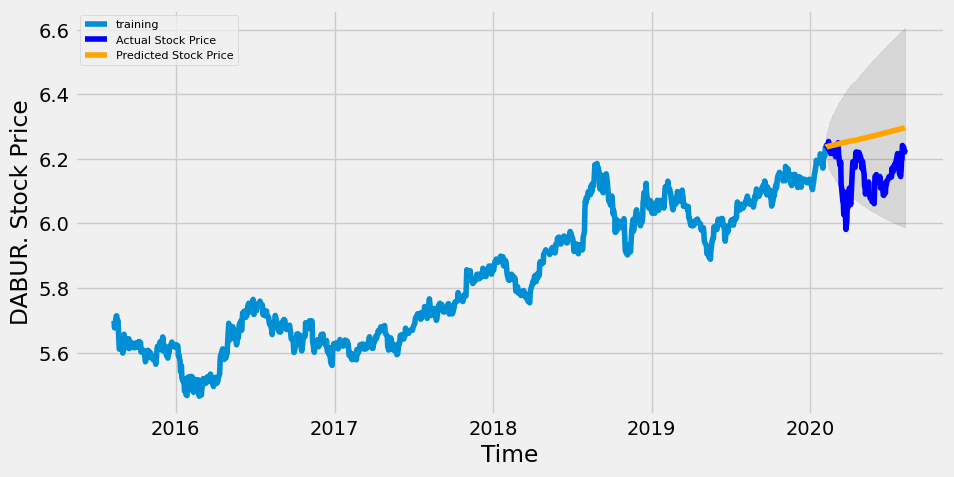

In [15]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.xlabel('Time')
plt.ylabel('DABUR. Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## So now we calculate MSE, MAE, RMSE and MAPE
## The results are as follows

In [16]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.017393022874347852
MAE: 0.11452598904940245
RMSE: 0.13188261020448394
MAPE: 0.01872082926823462
